In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import epam.toy_simulation as toy_simulation
from epam.sequences import translate_sequences
from epam.toy_simulation import mimic_aa_mutations
from epam.toy_dnsm import train_model

In [2]:
aa_parents = pd.Series(["YYAYYYY", "YFY", "CYTFD", "KAY"])
aa_sub_counts = pd.Series([3, 2, 4, 1])

mimic_aa_mutations(
    toy_simulation.hydrophobic_neighbor_mutator,
    aa_parents,
    aa_sub_counts,
)

0    YHRIYYY
1        YTD
2      RNDFC
3        KAN
dtype: object

In [3]:
pcp_df = pd.read_csv("~/data/wyatt-10x-1p5m_pcp_2023-10-07.csv", index_col=0)

# pcp_df = pcp_df.head(100)

pcp_df["aa_parent"] = translate_sequences(pcp_df["parent"])
pcp_df["aa_child"] = translate_sequences(pcp_df["child"])

pcp_df = pcp_df[pcp_df["aa_parent"] != pcp_df["aa_child"]].reset_index(drop=True)

pcp_df["aa_sub_count"] = pcp_df.apply(lambda row: sum([p != c for p, c in zip(row["aa_parent"], row["aa_child"])]), axis=1)

In [4]:
fake_df = pd.DataFrame({"aa_parent": pcp_df["aa_parent"], "aa_child": mimic_aa_mutations(toy_simulation.hydrophobic_mutator, pcp_df["aa_parent"], pcp_df["aa_sub_count"])})

fake_df["aa_sub_count"] = pcp_df.apply(lambda row: sum([p != c for p, c in zip(row["aa_parent"], row["aa_child"])]), axis=1)

assert (fake_df["aa_sub_count"] == pcp_df["aa_sub_count"]).all()

In [5]:
fake_df

,aa_parent,aa_child,aa_sub_count
0,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSSGMHWVRQAPGKGLE...,QVQLVESGGGEVQPGRSLRLSCAASGFTFSSSGMHWVRQAPGKGLE...,2
1,QVQLVESGGGVVQPGRSLRLSCAASGFTFNSSGMHWVRQAPGKGLE...,QVQLVESGGGVVQPGRSLRLSCAASGFTDNSSGMHWVRQAPGKGLE...,3
2,QVQLVESGGGVVQPGRSLRLSCAASGFTFDSSGMHWVRQAPGKGLE...,QMQLVESGGGVVQPGRSLRLSCAASGPTFDSSGMHWVRQAPGKGLE...,7
3,QVQLVESGGGVVQPGRSLRLSCATSGFNFDTSGMHWVRQAPGKGLE...,QVQLVESGGGVVQPGRSLRLSCLTSGFNFDTSGMHWVRQRPGKGLE...,9
4,QVQLVESGGGVVQPGRSLRLSCATSGFNFDTSGMHWVRQAPGKGLE...,QVQLVESGGGVVQPGRSLRMSCATSGFNFDTSGMHKVRQAPGKGLE...,4
...,...,...,...
55731,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,QLQVQESGPGLVKPSETSSLTCTVSGGSISSSSYYWGWIRQPPGKG...,8
55732,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,QLQLQESGPGLHKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,1
55733,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWCRQPPGKG...,3
55734,EVQLLESGGGLVQPGGSLRLSCAASGFTFSSFAMSWVRQAPGKGLE...,EVQLLESGGGLVQPGGSLRLSCAASGFTFSSFAMSWVRQAPGKGLE...,2


In [6]:
def y_count(seq):
    return sum([aa == "Y" for aa in seq])

fake_df["y_parent_count"] = fake_df["aa_parent"].apply(y_count)
fake_df["y_child_count"] = fake_df["aa_child"].apply(y_count)
fake_df["y_diff"] = fake_df["y_child_count"] - fake_df["y_parent_count"]
fake_df["y_diff"].value_counts()

y_diff
 0    26450
-1    15054
-2     5992
 1     4016
-3     2426
-4      887
 2      406
-5      329
-6       85
 3       46
-7       33
 4        5
-8        4
-9        3
Name: count, dtype: int64

In [7]:
!rm _logs/*

nhead = 4
dim_feedforward = 2048
layer_count = 4
model = train_model(fake_df, nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count, batch_size=1024, num_epochs=10, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

preparing data...
Using Metal Performance Shaders
Epoch [0/10], Training Loss: 2.5866519754583184, Validation Loss: 2.5325369834899902
Epoch [1/10], Training Loss: 0.30605706572532654, Validation Loss: 0.2962842041795904
Epoch [2/10], Training Loss: 0.24041339755058289, Validation Loss: 0.23607189817862076
Epoch [3/10], Training Loss: 0.21484725177288055, Validation Loss: 0.20643444765697827
Epoch [4/10], Training Loss: 0.19077248871326447, Validation Loss: 0.1923413181846792
Epoch [5/10], Training Loss: 0.19351862370967865, Validation Loss: 0.18577415970238773
Epoch [6/10], Training Loss: 0.1909681260585785, Validation Loss: 0.18285809728232297
Epoch [7/10], Training Loss: 0.1792934536933899, Validation Loss: 0.181653538888151
Epoch [8/10], Training Loss: 0.18340784311294556, Validation Loss: 0.18121729249303992
Epoch [9/10], Training Loss: 0.1772642880678177, Validation Loss: 0.1811047833074223
Epoch [10/10], Training Loss: 0.17517529428005219, Validation Loss: 0.18110449476675552


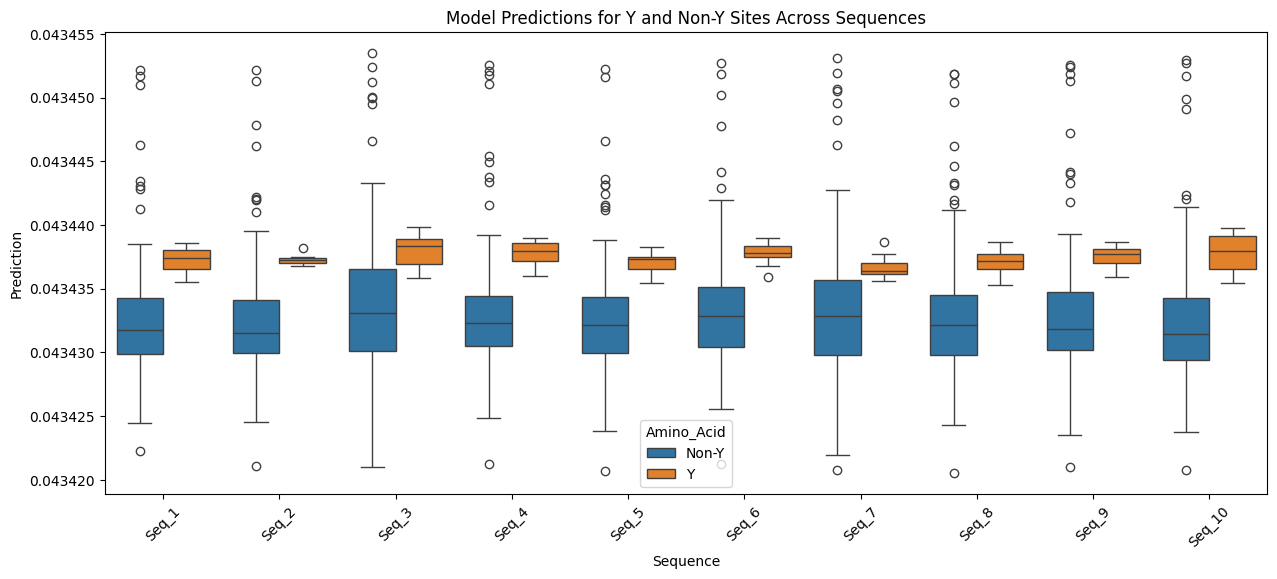

In [8]:
# Sample 10 amino acid sequences from a column in your DataFrame
aa_sequences = fake_df["aa_parent"].sample(n=10)

# Initialize an empty list to store rows
rows = []

# Populate the list with model predictions
for seq_index, aa_sequence in enumerate(aa_sequences):
    predictions = model.prediction_of_aa_str(aa_sequence)
    
    for pos, (aa, pred) in enumerate(zip(aa_sequence, predictions)):
        row = {
            'Sequence': f'Seq_{seq_index + 1}',
            'Position': pos,
            'Amino_Acid': 'Y' if aa == 'Y' else 'Non-Y',
            'Prediction': pred
        }
        rows.append(row)

# Convert list of rows to DataFrame
df = pd.DataFrame(rows)

# Create a plot with sequences as x-ticks
plt.figure(figsize=(15, 6))
sns.boxplot(x='Sequence', y='Prediction', hue='Amino_Acid', data=df)
plt.xticks(rotation=45)
plt.title('Model Predictions for Y and Non-Y Sites Across Sequences')
plt.show()
